# HNCDI Explain:  Grover Tutorial 2

This is tutorial 3 on Grover's Algorithm. This is a 3-qubit example, with 1-Grover iteration. 

__Task__. Run through the provided notebook, which steps through the stages of Grover's algorithm. Notice that the good item $x_m=111$ still occurs with high probability, but the other strings now have non-zero probability.

In [1]:
import numpy as np
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit_aer.primitives import SamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as real_sampler
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile

### Authenticate with IBM quantum

You will require the API token specified in the IBM quantum platform to ensure you can execute your code on a real quantum computer.

In [23]:
my_token = "<Paste your token here>"

service = QiskitRuntimeService(channel="ibm_quantum", token=my_token)

As in tutorial 1, we will now step through Grover's algorithm but for 3-qubits. 

__Step 1__: Create the superposition state $|s \rangle$.

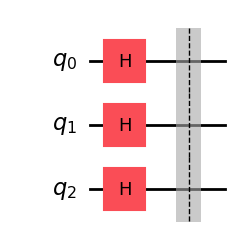

In [8]:
# Define no. of qubits to be n = 3 and create a quantum circuit called "circ" with an n-qubit register.
n = 3
circ = QuantumCircuit(n)

#Apply a Hadamard gate to each qubit in the circuit.
for i in range(n):
    circ.h(i)
    
circ.barrier()
circ.draw('mpl') 

__Step 2__. Here we create the circuit that implements the oracle that marks the good item $111$. The circuit that implements this is the $CCZ$ gate. 

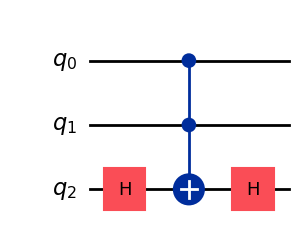

In [9]:
qc = QuantumCircuit(3)

## mark item 111
qc.h([2])
qc.ccx(0,1,2)
qc.h([2])
qc.draw('mpl')

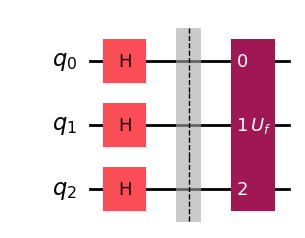

In [10]:
oracle = qc.to_gate()
oracle.name = "$U_f$"
circ.append(oracle, [0,1,2])
circ.draw('mpl') 

__Step 3__. Apply the Grover Diffusion operator.

In [11]:
# This is code provides a general implementation of Grover's Diffusion operator, based on https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm.
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_D$"
    return U_s

{'This is the final Grover Circuit with 1-iteration.'}


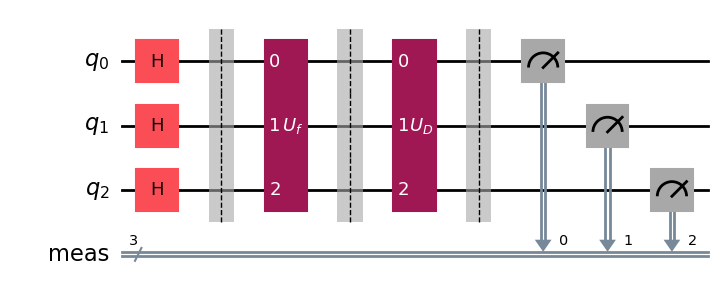

In [12]:
circ.barrier()
circ.append(diffuser(n), [0,1,2])
circ.draw()
circ.measure_all()
print({'This is the final Grover Circuit with 1-iteration.'})
circ.draw('mpl') 

__Step 4__: We will now submit the quantum circuit to A) a simulator and B) a real quantum computer. 

Notice that the marked item $x_m = 111$ was identified with high probability with only one Grover-iteration, however unlike tutorial 1 the other strings now have non-zero probability.

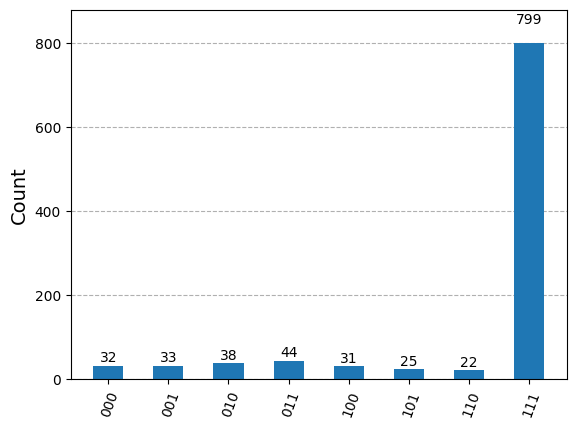

In [21]:
# OPTION 1: RUN ON QUANTUM SIMULATOR
sim = AerSimulator()
sampler = SamplerV2()
t_circ = transpile(circ, sim, optimization_level=3)
results = sampler.run([t_circ], shots=1024).result()
answer = results[0].data.meas.get_counts()
plot_histogram(answer)

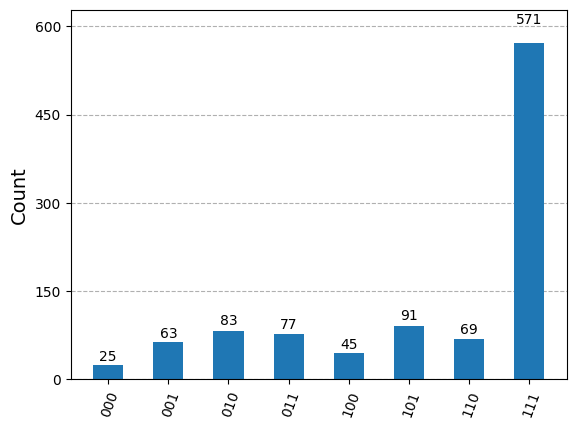

In [24]:
# OPTION 2: RUN ON QUANTUM HARDWARE

backend = service.least_busy(operational=True, simulator=False)
sampler = real_sampler(backend)
t_circ = transpile(circ, backend, optimization_level=3)
job = sampler.run([t_circ], shots=1024)
results = job.result()
answer = results[0].data.meas.get_counts()
plot_histogram(answer)